In [7]:
# ---------------------------------------------------------------
# Read nsig ± nsig_err from every ROOT file
# and store them as 'ufloat' objects
# ---------------------------------------------------------------
from pathlib import Path
import uproot
import numpy as np
from uncertainties import ufloat, unumpy as unp   # for error propagation

ROOT_DIR = Path(".")   # adjust if needed

# keep only real .root files (ignore EOS version folders)
root_files = [p for p in ROOT_DIR.glob("*.root") if p.is_file()]
print(f"Processing {len(root_files)} ROOT files\n")

u_nsig = []    # one NumPy array of ufloat per file  (same order as root_files)

for fpath in root_files:
    print(f"=== {fpath.name} ===")
    with uproot.open(fpath) as rf:
        if "fit_results" not in rf:
            print("  [no TTree 'fit_results' → skipping]\n")
            continue

        tree = rf["fit_results"]

        # read the numeric branches
        arr_nsig     = tree["nsig"    ].array(library="np")
        arr_nsig_err = tree["nsig_err"].array(library="np")

        # combine value + error into one ufloat per entry
        arr_u = unp.uarray(arr_nsig, arr_nsig_err)   # vectorised creation
        u_nsig.append(arr_u)

        # pretty-print every entry
        for idx, val in enumerate(arr_u):
            print(f"  entry {idx:2d}: {val}")        # shows  1234.0+/-56.0
        print()

print("---------------------------------------------------------------")
print(f"Built list 'u_nsig'  →  len(u_nsig) = {len(u_nsig)}")
print("Each element is a NumPy array of ufloats matching that file's entries.")

Processing 50 ROOT files

=== 2024_B2OC_UP_B5_F10097.root ===
  entry  0: (4.88+/-0.07)e+04

=== 2024_B2CC_UP_B5_F10061.root ===
  entry  0: (2.83+/-0.07)e+04

=== 2024_B2CC_UP_B5_F10077.root ===
  entry  0: (5.31+/-0.05)e+04

=== 2024_B2CC_UP_B5_F10098.root ===
  entry  0: (2.82+/-0.04)e+04

=== 2024_B2OC_UP_B5_F10074.root ===
  entry  0: (5.32+/-0.06)e+04

=== 2024_B2CC_UP_B5_F10082.root ===
  entry  0: (1.357+/-0.027)e+04

=== 2024_B2CC_UP_B5_F10094.root ===
  entry  0: (1.99+/-0.08)e+04

=== 2024_B2CC_UP_B5_F10095.root ===
  entry  0: (8.06+/-0.07)e+04

=== 2024_B2OC_UP_B5_F10059.root ===
  entry  0: (6.96+/-0.25)e+03

=== 2024_B2OC_UP_B5_F10075.root ===
  entry  0: (1.389+/-0.031)e+04

=== 2024_B2CC_UP_B5_F10099.root ===
  entry  0: (3.45+/-0.04)e+04

=== 2024_B2OC_UP_B5_F10096.root ===
  entry  0: (2.13+/-0.05)e+04

=== 2024_B2OC_UP_B5_F10072.root ===
  entry  0: (5.24+/-0.06)e+04

=== 2024_B2CC_UP_B5_F10084.root ===
  entry  0: (1.341+/-0.022)e+05

=== 2024_B2CC_UP_B5_F10092.roo

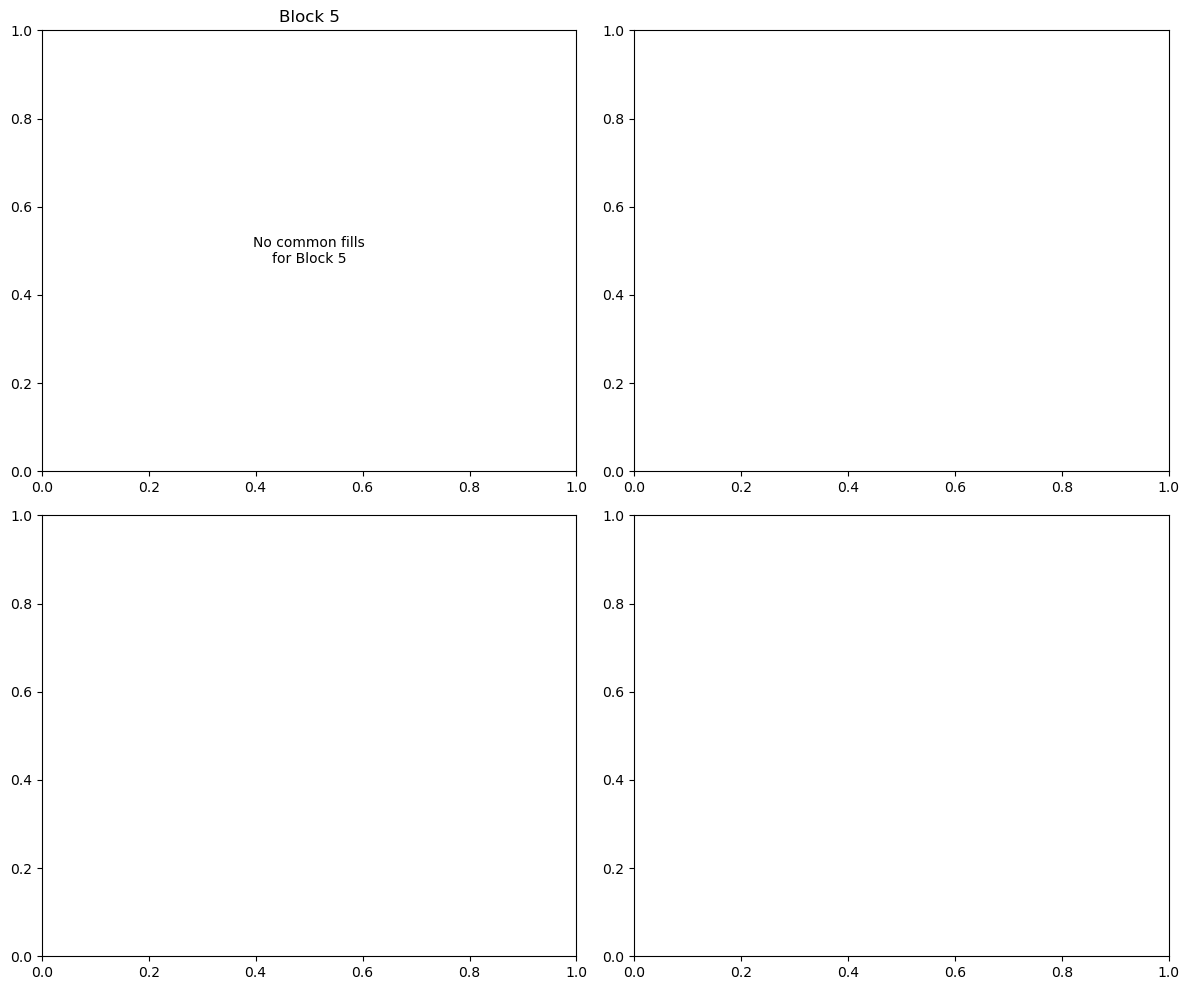

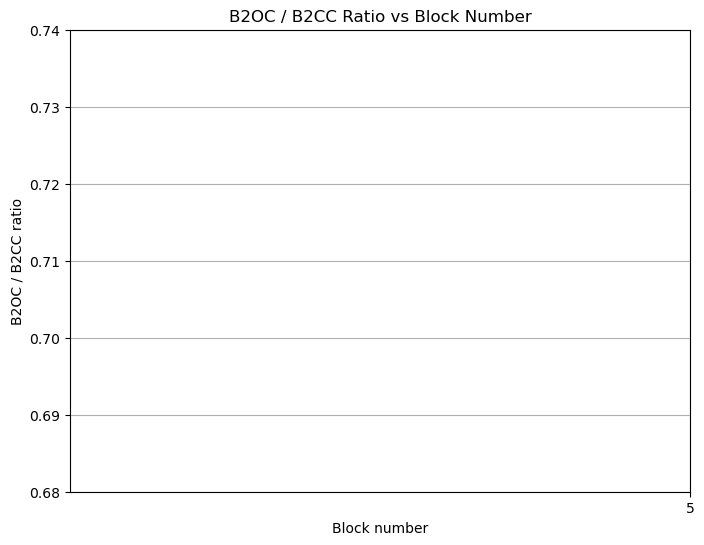


SUMMARY TABLE: B2OC / B2CC Ratios by Block
Block  Ratio        Error        χ²/ndf   Fills
------------------------------------------------------------
5      No data      ---          ---      []


In [11]:
# ---------------------------------------------------------------
# Plot B2OC / B2CC yield ratio for ALL blocks (5, 6, 7, 8)
# ---------------------------------------------------------------
import re
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from scipy.optimize import curve_fit

# 1) Gather total nsig per (campaign, block, fill)
tot = {"B2OC": {}, "B2CC": {}}
blocks = [5]

for block in blocks:
    tot["B2OC"][block] = {}
    tot["B2CC"][block] = {}

for path, arr_u in zip(root_files, u_nsig):
    fname = path.name.upper()

    # extract block number
    block_match = re.search(r"B(\d+)", fname)
    if not block_match:
        continue
    block = int(block_match.group(1))
    
    # only process blocks 5, 6, 7, 8
    if block not in blocks:
        continue

    # campaign tag
    if   "B2OC" in fname:
        camp = "B2OC"
    elif "B2CC" in fname:
        camp = "B2CC"
    else:
        continue

    # extract fill number, e.g. "…_F10059"
    fill_match = re.search(r"_F(\d+)", fname)
    if not fill_match:
        continue
    fill = int(fill_match.group(1))

    # total yield in this file (value + error propagate)
    tot[camp][block][fill] = arr_u.sum()

# 2) Plot each block separately
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

block_colors = ['blue', 'green', 'red', 'orange']
all_fits = {}

for i, block in enumerate(blocks):
    ax = axes[i]
    
    # Build ratios for fills that appear in both campaigns for this block
    fills = sorted(set(tot["B2OC"][block]) & set(tot["B2CC"][block]))
    
    if len(fills) == 0:
        ax.text(0.5, 0.5, f"No common fills\nfor Block {block}", 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"Block {block}")
        continue
    
    rat_u = [tot["B2OC"][block][f] / tot["B2CC"][block][f] for f in fills]
    rat_val = unp.nominal_values(rat_u)
    rat_err = unp.std_devs(rat_u)
    
    # Plot
    ax.errorbar(fills, rat_val, yerr=rat_err, fmt='o', capsize=5,
                color=block_colors[i], ecolor=block_colors[i], 
                label=f'B2OC / B2CC (Block {block})')
    ax.set_xlabel("Fill number")
    ax.set_ylabel("Yield ratio")
    ax.set_ylim(0.60, 0.80) 
    ax.grid(True)
    
    # Fit to a constant
    def const(x, a): return a
    if len(fills) > 1:
        popt, pcov = curve_fit(const, fills, rat_val, sigma=rat_err)
        a_fit = popt[0]
        sig_a = np.sqrt(pcov[0,0])
        
        chi2 = np.sum(((rat_val - a_fit)/rat_err)**2)
        chi2rd = chi2 / (len(fills) - 1) if len(fills) > 1 else 0
        
        ax.axhline(a_fit, color='red', linestyle='--', alpha=0.7,
                   label=f"Fit: {a_fit:.3f} ± {sig_a:.3f}")
        ax.set_title(f"Block {block}   χ²/ndf = {chi2rd:.2f}")
        
        all_fits[block] = {'ratio': a_fit, 'error': sig_a, 'chi2rd': chi2rd, 'fills': fills}
    else:
        ax.set_title(f"Block {block} (single fill)")
        all_fits[block] = {'ratio': rat_val[0], 'error': rat_err[0], 'chi2rd': 0, 'fills': fills}
    
    ax.legend()
    
    # Print numerical results for this block
    print(f"\n=== Block {block} ===")
    print(f"Fills: {fills}")
    print("Ratio per fill (value ±1σ):")
    for f, r in zip(fills, rat_u):
        print(f"  fill {f}:  {r}")
    
    if len(fills) > 1:
        print(f"Constant fit:  a = {a_fit:.6f} ± {sig_a:.6f}")
        print(f"χ² = {chi2:.2f}  for {len(fills)-1} dof  →  χ²/ndf = {chi2rd:.2f}")

plt.tight_layout()
plt.show()

# 3) Summary plot: Compare fitted ratios across blocks
plt.figure(figsize=(8, 6))
block_nums = []
block_ratios = []
block_errors = []

for block in blocks:
    if block in all_fits:
        block_nums.append(block)
        block_ratios.append(all_fits[block]['ratio'])
        block_errors.append(all_fits[block]['error'])

plt.errorbar(block_nums, block_ratios, yerr=block_errors, fmt='o-', capsize=5,
             color='black', ecolor='black', linewidth=2, markersize=8)
plt.xlabel("Block number")
plt.ylabel("B2OC / B2CC ratio")
plt.ylim(0.68, 0.74)
plt.title("B2OC / B2CC Ratio vs Block Number")
plt.grid(True)
plt.xticks(blocks)

# Add text annotations with chi2/ndf
for block, ratio, error in zip(block_nums, block_ratios, block_errors):
    chi2rd = all_fits[block]['chi2rd']
    plt.annotate(f'χ²/ndf = {chi2rd:.2f}', 
                xy=(block, ratio), xytext=(5, 5), 
                textcoords='offset points', fontsize=8)

plt.show()

# 4) Print summary table
print("\n" + "="*60)
print("SUMMARY TABLE: B2OC / B2CC Ratios by Block")
print("="*60)
print(f"{'Block':<6} {'Ratio':<12} {'Error':<12} {'χ²/ndf':<8} {'Fills'}")
print("-"*60)
for block in blocks:
    if block in all_fits:
        fit = all_fits[block]
        fills_str = str(fit['fills'])
        print(f"{block:<6} {fit['ratio']:<12.6f} {fit['error']:<12.6f} {fit['chi2rd']:<8.2f} {fills_str}")
    else:
        print(f"{block:<6} {'No data':<12} {'---':<12} {'---':<8} {'[]'}")

# 5) Overall stability check
if len(block_ratios) > 1:
    overall_mean = np.mean(block_ratios)
    overall_std = np.std(block_ratios, ddof=1)
    print(f"\nOverall stability:")
    print(f"Mean ratio across blocks: {overall_mean:.6f}")
    print(f"Standard deviation: {overall_std:.6f}")
    print(f"Relative variation: {(overall_std/overall_mean)*100:.3f}%")

In [1]:
import numpy as np

# Example data (fill, value, error)
data = [
    (10059, 0.760, 0.028),
    (10061, 0.721, 0.020),
    (10066, 0.720, 0.014),
    (10069, 0.715, 0.009),
    (10070, 0.720, 0.040),
    (10072, 0.712, 0.009),
    (10073, 0.728, 0.009),
    (10074, 0.734, 0.009),
    (10075, 0.730, 0.040),
    (10077, 0.711, 0.010),
    (10082, 0.729, 0.021),
    (10084, 0.720, 0.013),
    (10086, 0.746, 0.017),
    (10087, 0.712, 0.009),
    (10090, 0.687, 0.009),
    (10091, 0.707, 0.015),
    (10092, 0.705, 0.008),
    (10093, 0.672, 0.018),
    (10094, 0.705, 0.033),
    (10095, 0.707, 0.009),
    (10096, 0.683, 0.014),
    (10097, 0.709, 0.009),
    (10098, 0.700, 0.014),
    # (10099, 0.678, 0.012),
    # (10100, 0.722, 0.009)
]

# Fitted constant from your output
a_fit = 0.711103

# Compute chi2 per point
print(f"{'Fill':<8} {'Value':<10} {'Error':<10} {'Chi² contribution'}")
print("-" * 50)

chi2_total = 0

for fill, val, err in data:
    chi2_i = ((val - a_fit) / err)**2
    chi2_total += chi2_i
    print(f"{fill:<8} {val:<10.3f} {err:<10.3f} {chi2_i:.3f}")

print("\nTotal χ²:", round(chi2_total, 2))
print("ndf:", len(data) - 1)
print(f"χ²/ndf: {chi2_total / (len(data) - 1):.2f}")



Fill     Value      Error      Chi² contribution
--------------------------------------------------
10059    0.760      0.028      3.050
10061    0.721      0.020      0.245
10066    0.720      0.014      0.404
10069    0.715      0.009      0.187
10070    0.720      0.040      0.049
10072    0.712      0.009      0.010
10073    0.728      0.009      3.525
10074    0.734      0.009      6.473
10075    0.730      0.040      0.223
10077    0.711      0.010      0.000
10082    0.729      0.021      0.726
10084    0.720      0.013      0.468
10086    0.746      0.017      4.214
10087    0.712      0.009      0.010
10090    0.687      0.009      7.172
10091    0.707      0.015      0.075
10092    0.705      0.008      0.582
10093    0.672      0.018      4.719
10094    0.705      0.033      0.034
10095    0.707      0.009      0.208
10096    0.683      0.014      4.029
10097    0.709      0.009      0.055
10098    0.700      0.014      0.629

Total χ²: 37.09
ndf: 22
χ²/ndf: 1.69


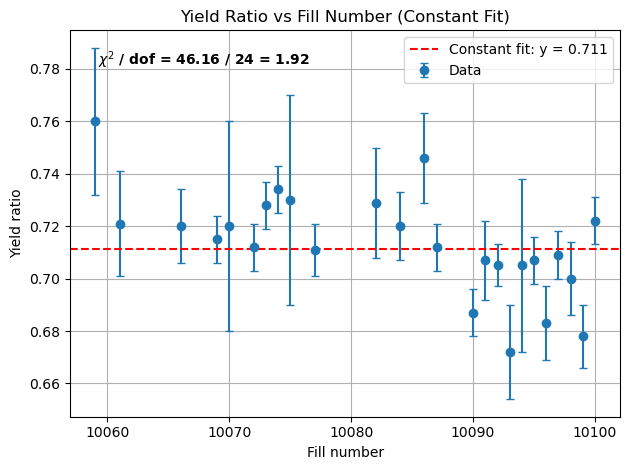

Chi-square contributions per point:
Fill 10059: chi2 = 3.04
Fill 10061: chi2 = 0.24
Fill 10066: chi2 = 0.40
Fill 10069: chi2 = 0.18
Fill 10070: chi2 = 0.05
Fill 10072: chi2 = 0.01
Fill 10073: chi2 = 3.49
Fill 10074: chi2 = 6.43
Fill 10075: chi2 = 0.22
Fill 10077: chi2 = 0.00
Fill 10082: chi2 = 0.72
Fill 10084: chi2 = 0.46
Fill 10086: chi2 = 4.19
Fill 10087: chi2 = 0.01
Fill 10090: chi2 = 7.22
Fill 10091: chi2 = 0.08
Fill 10092: chi2 = 0.60
Fill 10093: chi2 = 4.74
Fill 10094: chi2 = 0.04
Fill 10095: chi2 = 0.22
Fill 10096: chi2 = 4.05
Fill 10097: chi2 = 0.06
Fill 10098: chi2 = 0.64
Fill 10099: chi2 = 7.65
Fill 10100: chi2 = 1.44


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Input Data ---
data = [
    (10059, 0.760, 0.028),
    (10061, 0.721, 0.020),
    (10066, 0.720, 0.014),
    (10069, 0.715, 0.009),
    (10070, 0.720, 0.040),
    (10072, 0.712, 0.009),
    (10073, 0.728, 0.009),
    (10074, 0.734, 0.009),
    (10075, 0.730, 0.040),
    (10077, 0.711, 0.010),
    (10082, 0.729, 0.021),
    (10084, 0.720, 0.013),
    (10086, 0.746, 0.017),
    (10087, 0.712, 0.009),
    (10090, 0.687, 0.009),
    (10091, 0.707, 0.015),
    (10092, 0.705, 0.008),
    (10093, 0.672, 0.018),
    (10094, 0.705, 0.033),
    (10095, 0.707, 0.009),
    (10096, 0.683, 0.014),
    (10097, 0.709, 0.009),
    (10098, 0.700, 0.014),
    (10099, 0.678, 0.012),
    (10100, 0.722, 0.009)
]

# --- Convert to arrays ---
fills, values, errors = zip(*data)
fills = np.array(fills)
values = np.array(values)
errors = np.array(errors)

def constant(x, c):
    return np.full(x.shape, c, dtype=float)


# --- Fit to a constant ---
popt, pcov = curve_fit(constant, fills, values, sigma=errors, absolute_sigma=True)
c = popt[0]

# --- Evaluate fit ---
fit_values = constant(fills, c)
residuals = values - fit_values
chi2_contributions = (residuals / errors) ** 2
chi2_total = np.sum(chi2_contributions)
dof = len(fills) - len(popt)
chi2_ndof = chi2_total / dof

# --- Plot ---
plt.errorbar(fills, values, yerr=errors, fmt='o', capsize=3, label='Data')
plt.axhline(c, color='red', linestyle='--', label=f'Constant fit: y = {c:.3f}')
plt.xlabel('Fill number')
plt.ylabel('Yield ratio')
plt.title('Yield Ratio vs Fill Number (Constant Fit)')
plt.grid(True)

# Annotate chi2 on plot
plt.text(0.05, 0.95,
         f"$\\chi^2$ / dof = {chi2_total:.2f} / {dof} = {chi2_ndof:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10,
         fontweight='bold',
         verticalalignment='top')

plt.legend()
plt.tight_layout()
plt.show()

# --- Print chi2 contributions ---
print("Chi-square contributions per point:")
for fill, chi2 in zip(fills, chi2_contributions):
    print(f"Fill {fill}: chi2 = {chi2:.2f}")
